In [24]:
from IPython import get_ipython
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

#### Convulational layers - filters, kernels, receptive fields


1.1 What are Kernels/Filters?
----------------------------------------
Original 8x8 Image (0=black, 1=white):
[[0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]]


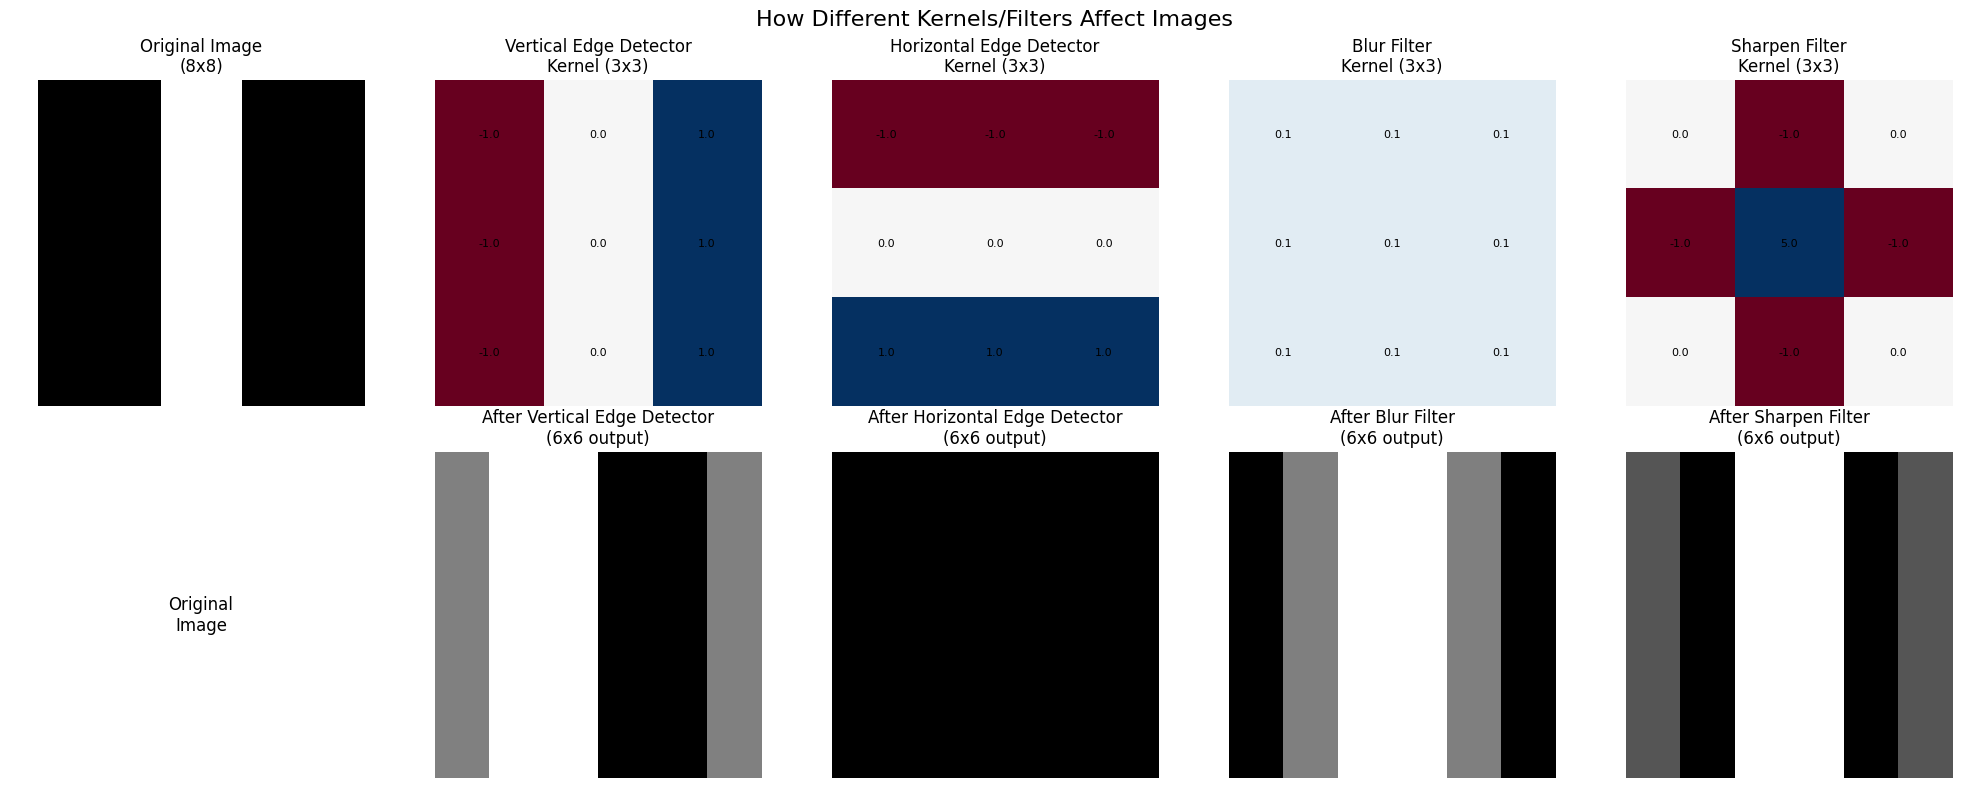

In [25]:
# 1.1 Understanding Kernels/Filters with Simple Examples
print("\n1.1 What are Kernels/Filters?")
print("-" * 40)

# Create a simple 8x8 image with a vertical edge
simple_image = np.zeros((8, 8))
simple_image[:, 3:5] = 1  # Create vertical white stripe
print("Original 8x8 Image (0=black, 1=white):")
print(simple_image)

# Define different types of kernels/filters
kernels = {
    'Vertical Edge Detector': np.array([[-1, 0, 1],
                                       [-1, 0, 1],
                                       [-1, 0, 1]]),

    'Horizontal Edge Detector': np.array([[-1, -1, -1],
                                         [ 0,  0,  0],
                                         [ 1,  1,  1]]),

    'Blur Filter': np.array([[1, 1, 1],
                            [1, 1, 1],
                            [1, 1, 1]]) / 9,

    'Sharpen Filter': np.array([[ 0, -1,  0],
                               [-1,  5, -1],
                               [ 0, -1,  0]])
}

# Function to apply convolution manually (simplified)
def apply_convolution(image, kernel):
    """Apply convolution operation manually for understanding"""
    result = np.zeros((image.shape[0]-2, image.shape[1]-2))  # Output size

    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            # Extract 3x3 patch from image
            patch = image[i:i+3, j:j+3]
            # Element-wise multiplication and sum (convolution)
            result[i, j] = np.sum(patch * kernel)

    return result

# Visualize different kernels and their effects
fig, axes = plt.subplots(2, len(kernels) + 1, figsize=(20, 8))

# Show original image
axes[0, 0].imshow(simple_image, cmap='gray')
axes[0, 0].set_title('Original Image\n(8x8)')
axes[0, 0].axis('off')
axes[1, 0].text(0.5, 0.5, 'Original\nImage', ha='center', va='center', fontsize=12)
axes[1, 0].axis('off')

# Apply each kernel
for idx, (name, kernel) in enumerate(kernels.items()):
    # Apply convolution
    filtered_image = apply_convolution(simple_image, kernel)

    # Show kernel
    axes[0, idx + 1].imshow(kernel, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, idx + 1].set_title(f'{name}\nKernel (3x3)')
    axes[0, idx + 1].axis('off')

    # Add kernel values as text
    for i in range(3):
        for j in range(3):
            axes[0, idx + 1].text(j, i, f'{kernel[i, j]:.1f}',
                                 ha='center', va='center', fontsize=8)

    # Show result
    axes[1, idx + 1].imshow(filtered_image, cmap='gray')
    axes[1, idx + 1].set_title(f'After {name}\n(6x6 output)')
    axes[1, idx + 1].axis('off')

plt.suptitle('How Different Kernels/Filters Affect Images', fontsize=16)
plt.tight_layout()
plt.show()

Receptive Field = Area of input that affects one output pixel

Layer 1: 3x3 kernel → Receptive field = 3x3
Layer 2: 3x3 kernel → Receptive field = 5x5
Layer 3: 3x3 kernel → Receptive field = 7x7

Each layer sees a LARGER area of the original image!


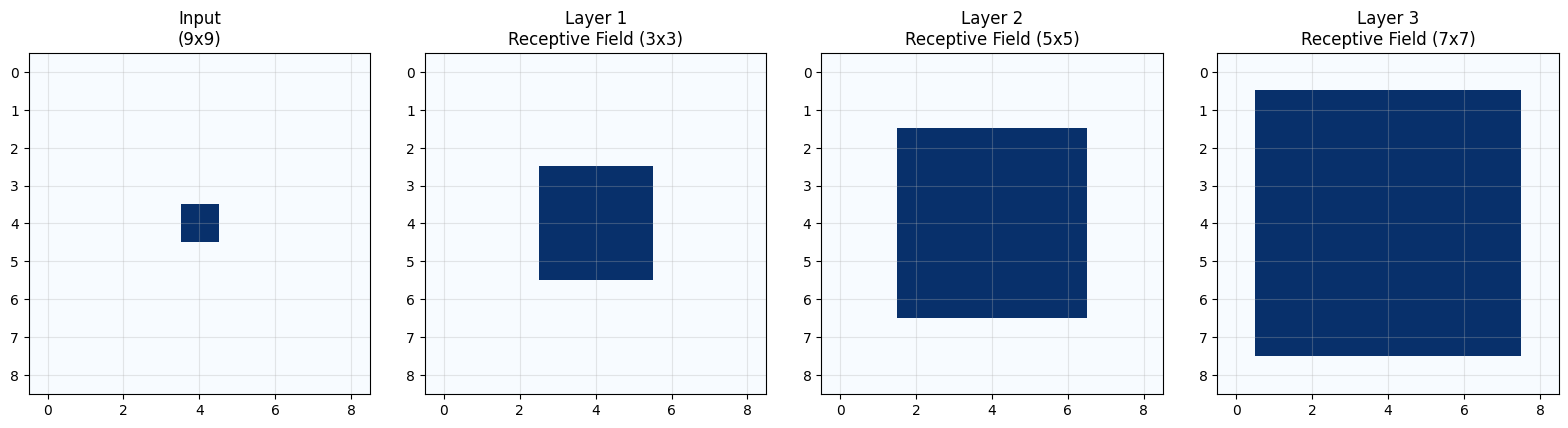

In [26]:
# Demonstrate receptive field concept
def demonstrate_receptive_field():
    """Show how receptive field grows with layers"""

    print("Receptive Field = Area of input that affects one output pixel")
    print("\nLayer 1: 3x3 kernel → Receptive field = 3x3")
    print("Layer 2: 3x3 kernel → Receptive field = 5x5")
    print("Layer 3: 3x3 kernel → Receptive field = 7x7")
    print("\nEach layer sees a LARGER area of the original image!")

    # Visual demonstration
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Original input
    input_size = 9
    original = np.zeros((input_size, input_size))
    original[4, 4] = 1  # Center pixel
    axes[0].imshow(original, cmap='Blues')
    axes[0].set_title('Input\n(9x9)')
    axes[0].grid(True, alpha=0.3)

    # Layer 1 receptive field
    layer1_rf = np.zeros((input_size, input_size))
    layer1_rf[3:6, 3:6] = 0.5  # 3x3 area
    axes[1].imshow(layer1_rf, cmap='Blues')
    axes[1].set_title('Layer 1\nReceptive Field (3x3)')
    axes[1].grid(True, alpha=0.3)

    # Layer 2 receptive field
    layer2_rf = np.zeros((input_size, input_size))
    layer2_rf[2:7, 2:7] = 0.5  # 5x5 area
    axes[2].imshow(layer2_rf, cmap='Blues')
    axes[2].set_title('Layer 2\nReceptive Field (5x5)')
    axes[2].grid(True, alpha=0.3)

    # Layer 3 receptive field
    layer3_rf = np.zeros((input_size, input_size))
    layer3_rf[1:8, 1:8] = 0.5  # 7x7 area
    axes[3].imshow(layer3_rf, cmap='Blues')
    axes[3].set_title('Layer 3\nReceptive Field (7x7)')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

demonstrate_receptive_field()

#### Hierarchial feature representation in CNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


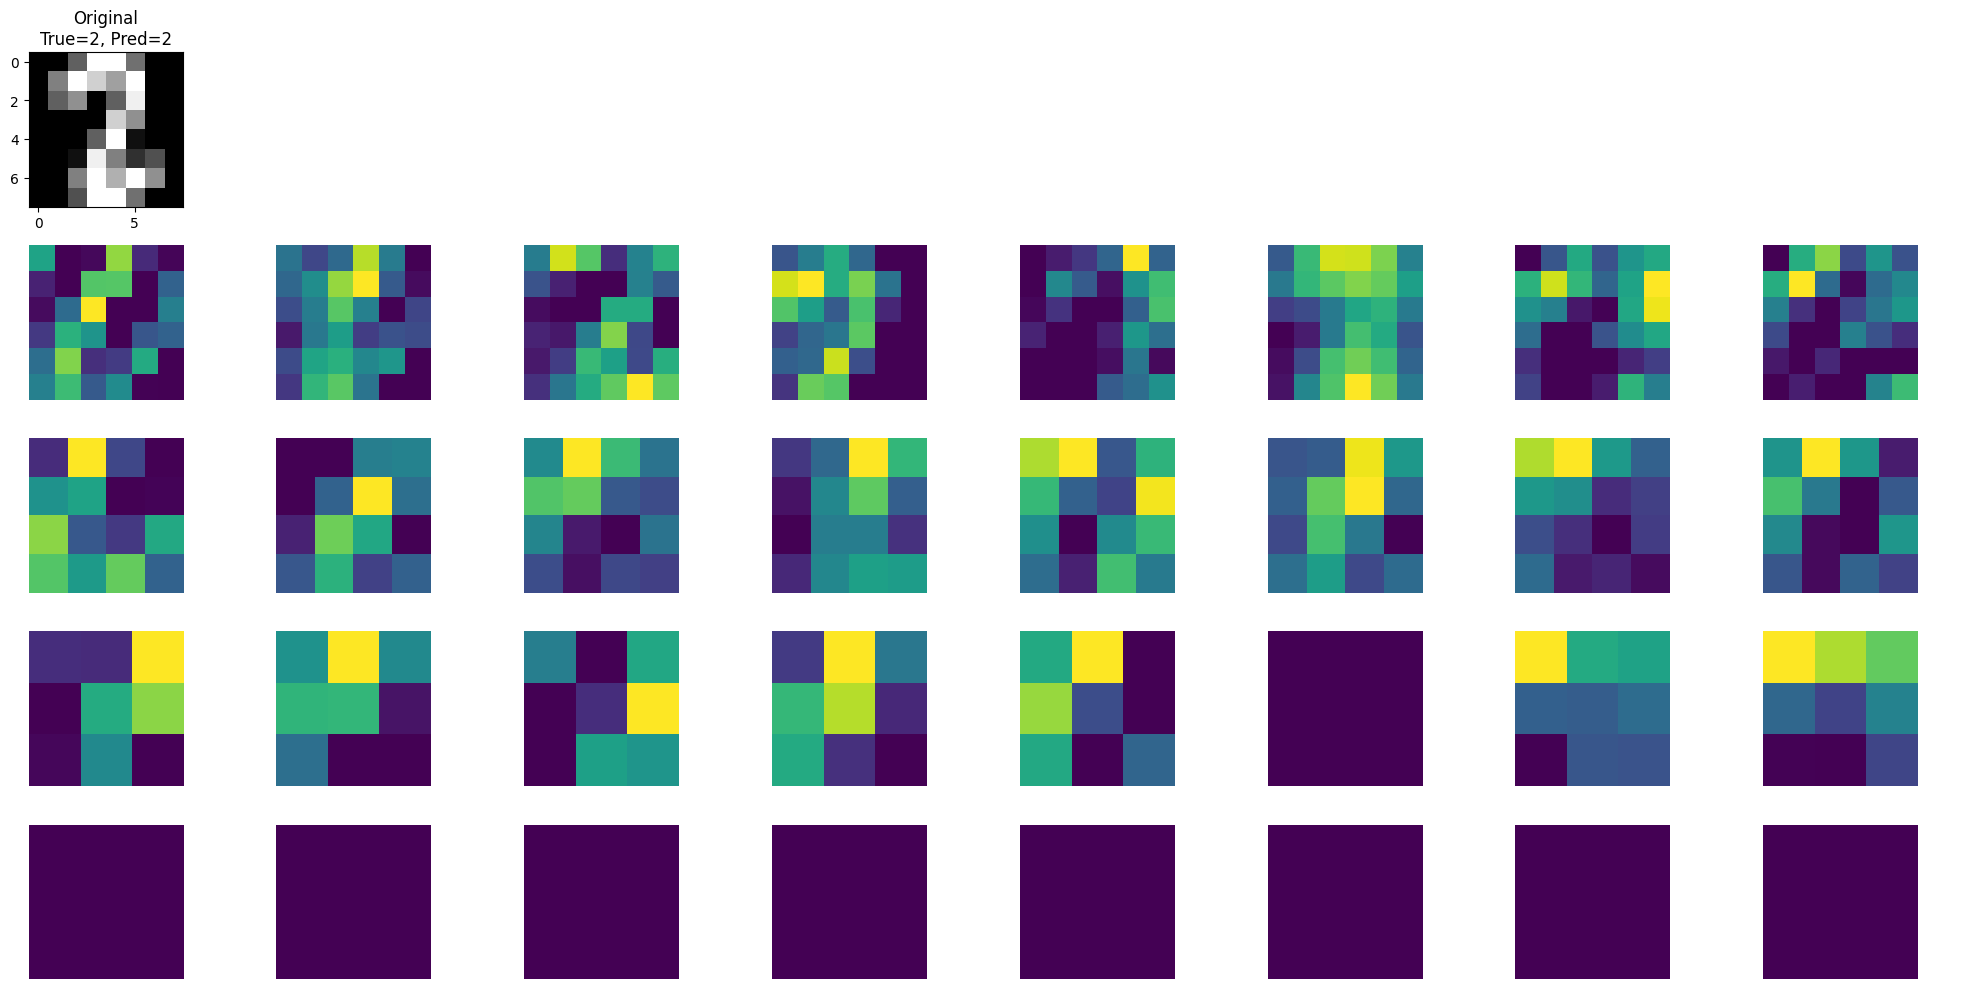

In [28]:
# Load and preprocess the dataset
digits = load_digits()
X_digits = digits.data.reshape(-1, 8, 8, 1) / 16.0  # Normalize to 0-1
y_digits = digits.target
X_sample = X_digits[:800]
y_sample = y_digits[:800]
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Define CNN model
def create_cnn_for_analysis():
    model = keras.Sequential([
        layers.Conv2D(8, (3, 3), activation='relu', input_shape=(8, 8, 1), name='early_conv1'),
        layers.Conv2D(16, (3, 3), activation='relu', name='early_conv2'),
        layers.Conv2D(32, (2, 2), activation='relu', name='middle_conv1'),
        layers.Conv2D(32, (2, 2), activation='relu', name='middle_conv2'),
        layers.Conv2D(64, (2, 2), activation='relu', name='deep_conv1'),
        layers.Flatten(),
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dense(10, activation='softmax', name='output')
    ])
    return model

# Build and train the model
cnn_model = create_cnn_for_analysis()

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0)

input_tensor = keras.Input(shape=(8, 8, 1))

# Manually build the forward pass through the layers of interest
x = input_tensor # Start with the input tensor
layer_outputs = []
layer_names = ['early_conv1', 'early_conv2', 'middle_conv1', 'deep_conv1'] # Layers to visualize

for layer in cnn_model.layers:
    x = layer(x) # Apply the current layer to the output of the previous layer

    if layer.name in layer_names:
        layer_outputs.append(x)


# Create the activation model using the explicit input_tensor and the collected layer outputs
activation_model = keras.Model(inputs=input_tensor, outputs=layer_outputs)

def visualize_layer_features(activation_model, input_image):
    input_tensor_reshaped = input_image.reshape(1, 8, 8, 1)
    # Predict using the pre-defined activation model
    activations = activation_model.predict(input_tensor_reshaped, verbose=0)
    return activations

# Choose a test image
test_image = X_test[0]
true_label = y_test[0]
# Predict the label using the trained model
predicted_label = np.argmax(cnn_model.predict(test_image.reshape(1, 8, 8, 1), verbose=0))

# Get activations using the fixed visualize_layer_features function
activations = visualize_layer_features(activation_model, test_image)

# Plot original image and feature maps
fig, axes = plt.subplots(len(layer_names) + 1, 8, figsize=(20, 10))
axes[0, 0].imshow(test_image.squeeze(), cmap='gray')
axes[0, 0].set_title(f'Original\nTrue={true_label}, Pred={predicted_label}')
for j in range(1, 8):
    axes[0, j].axis('off')

for i, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    # Display up to 8 channels per layer
    for j in range(min(8, num_channels)):
        axes[i + 1, j].imshow(activation[0, :, :, j], cmap='viridis')
        axes[i + 1, j].axis('off')
    # Turn off remaining axes if fewer than 8 channels
    for j in range(num_channels, 8):
        axes[i + 1, j].axis('off')
    # Add layer name as ylabel
    axes[i + 1, 0].set_ylabel(layer_names[i], rotation=0, labelpad=40, fontsize=12)

plt.tight_layout()
plt.show()

#### Pooling layers

Original 4x4 Feature Map:
[[1 3 2 4]
 [5 6 1 2]
 [2 1 8 3]
 [4 7 2 1]]

After 2x2 Max Pooling:
[[6. 4.]
 [7. 8.]]

After 2x2 Average Pooling:
[[3.75 2.25]
 [3.5  3.5 ]]


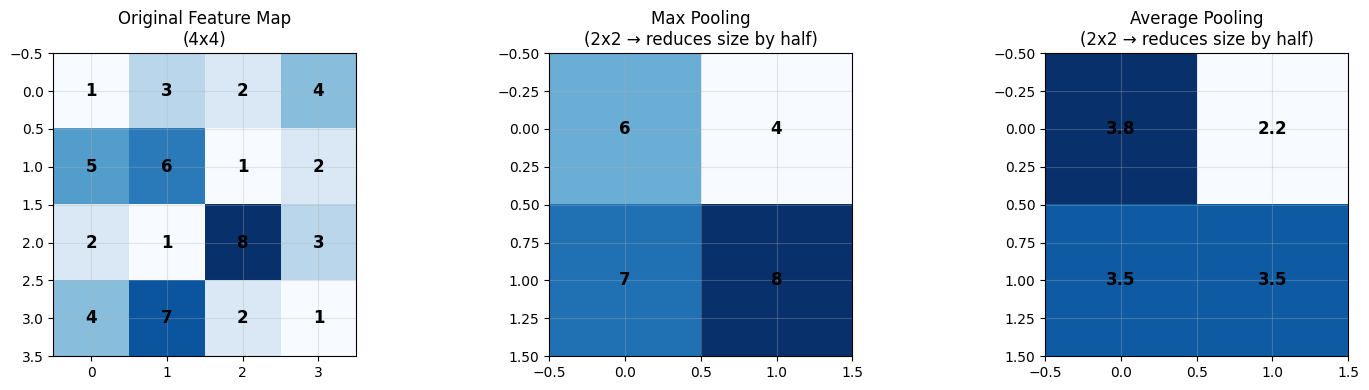

In [29]:
# Create a sample feature map for pooling demonstration
sample_feature_map = np.array([
    [1, 3, 2, 4],
    [5, 6, 1, 2],
    [2, 1, 8, 3],
    [4, 7, 2, 1]
])

print("Original 4x4 Feature Map:")
print(sample_feature_map)

# Implement different pooling operations manually
def max_pooling_2x2(feature_map):
    """Apply 2x2 max pooling"""
    h, w = feature_map.shape
    result = np.zeros((h//2, w//2))

    for i in range(0, h, 2):
        for j in range(0, w, 2):
            # Take 2x2 patch and find maximum
            patch = feature_map[i:i+2, j:j+2]
            result[i//2, j//2] = np.max(patch)

    return result

def average_pooling_2x2(feature_map):
    """Apply 2x2 average pooling"""
    h, w = feature_map.shape
    result = np.zeros((h//2, w//2))

    for i in range(0, h, 2):
        for j in range(0, w, 2):
            # Take 2x2 patch and find average
            patch = feature_map[i:i+2, j:j+2]
            result[i//2, j//2] = np.mean(patch)

    return result

# Apply different pooling operations
max_pooled = max_pooling_2x2(sample_feature_map)
avg_pooled = average_pooling_2x2(sample_feature_map)

print(f"\nAfter 2x2 Max Pooling:")
print(max_pooled)
print(f"\nAfter 2x2 Average Pooling:")
print(avg_pooled)

# Visualize pooling effects
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original
im1 = axes[0].imshow(sample_feature_map, cmap='Blues', interpolation='nearest')
axes[0].set_title('Original Feature Map\n(4x4)')
axes[0].grid(True, alpha=0.3)
for i in range(4):
    for j in range(4):
        axes[0].text(j, i, str(sample_feature_map[i, j]),
                    ha='center', va='center', fontsize=12, fontweight='bold')

# Max pooled
im2 = axes[1].imshow(max_pooled, cmap='Blues', interpolation='nearest')
axes[1].set_title('Max Pooling\n(2x2 → reduces size by half)')
axes[1].grid(True, alpha=0.3)
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, str(int(max_pooled[i, j])),
                    ha='center', va='center', fontsize=12, fontweight='bold')

# Average pooled
im3 = axes[2].imshow(avg_pooled, cmap='Blues', interpolation='nearest')
axes[2].set_title('Average Pooling\n(2x2 → reduces size by half)')
axes[2].grid(True, alpha=0.3)
for i in range(2):
    for j in range(2):
        axes[2].text(j, i, f'{avg_pooled[i, j]:.1f}',
                    ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Training CNN WITH pooling...
Training CNN WITHOUT pooling...

3.3 Pooling Comparison Results
----------------------------------------
MODEL COMPLEXITY:
With Pooling - Total parameters: 3,626
Without Pooling - Total parameters: 23,114

FINAL PERFORMANCE:
With Pooling - Val Accuracy: 0.919
Without Pooling - Val Accuracy: 0.956


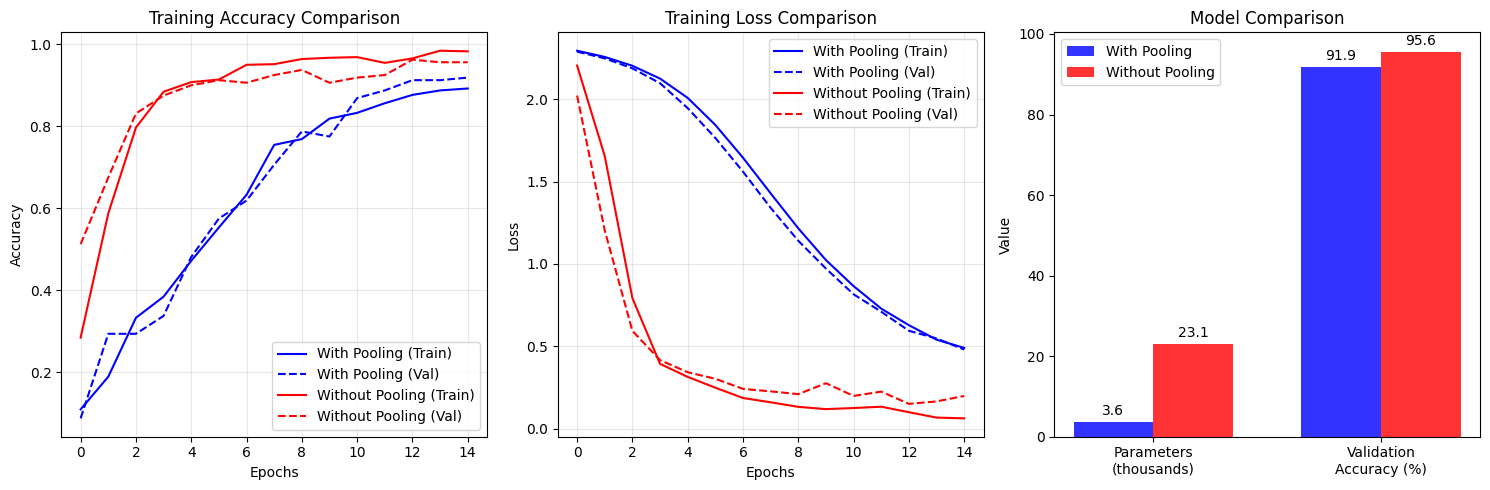

In [30]:
# Compare CNNs with and without pooling
def create_cnn_with_pooling():
    """CNN with pooling layers"""
    model = keras.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(8, 8, 1)),
        layers.MaxPooling2D((2, 2)),  # Reduces size by half
        layers.Conv2D(32, (2, 2), activation='relu'),
        layers.MaxPooling2D((2, 2)),  # Reduces size again
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='softmax')
    ], name='CNN_with_pooling')
    return model

def create_cnn_without_pooling():
    """CNN without pooling layers"""
    model = keras.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(8, 8, 1)),
        layers.Conv2D(32, (2, 2), activation='relu'),
        layers.Conv2D(32, (2, 2), activation='relu'),  # Extra conv instead of pooling
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='softmax')
    ], name='CNN_without_pooling')
    return model

# Train both models
print("Training CNN WITH pooling...")
model_with_pool = create_cnn_with_pooling()
model_with_pool.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_with_pool = model_with_pool.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), verbose=0)

print("Training CNN WITHOUT pooling...")
model_without_pool = create_cnn_without_pooling()
model_without_pool.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_without_pool = model_without_pool.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), verbose=0)

# Compare model sizes and performance
print("\n3.3 Pooling Comparison Results")
print("-" * 40)

print("MODEL COMPLEXITY:")
print(f"With Pooling - Total parameters: {model_with_pool.count_params():,}")
print(f"Without Pooling - Total parameters: {model_without_pool.count_params():,}")

print("\nFINAL PERFORMANCE:")
print(f"With Pooling - Val Accuracy: {history_with_pool.history['val_accuracy'][-1]:.3f}")
print(f"Without Pooling - Val Accuracy: {history_without_pool.history['val_accuracy'][-1]:.3f}")

# Plot training comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_with_pool.history['accuracy'], label='With Pooling (Train)', color='blue')
plt.plot(history_with_pool.history['val_accuracy'], label='With Pooling (Val)', color='blue', linestyle='--')
plt.plot(history_without_pool.history['accuracy'], label='Without Pooling (Train)', color='red')
plt.plot(history_without_pool.history['val_accuracy'], label='Without Pooling (Val)', color='red', linestyle='--')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history_with_pool.history['loss'], label='With Pooling (Train)', color='blue')
plt.plot(history_with_pool.history['val_loss'], label='With Pooling (Val)', color='blue', linestyle='--')
plt.plot(history_without_pool.history['loss'], label='Without Pooling (Train)', color='red')
plt.plot(history_without_pool.history['val_loss'], label='Without Pooling (Val)', color='red', linestyle='--')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
categories = ['Parameters', 'Val Accuracy']
with_pooling_values = [model_with_pool.count_params()/1000, history_with_pool.history['val_accuracy'][-1]*100]
without_pooling_values = [model_without_pool.count_params()/1000, history_without_pool.history['val_accuracy'][-1]*100]

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, with_pooling_values, width, label='With Pooling', alpha=0.8, color='blue')
plt.bar(x + width/2, without_pooling_values, width, label='Without Pooling', alpha=0.8, color='red')

plt.ylabel('Value')
plt.title('Model Comparison')
plt.xticks(x, ['Parameters\n(thousands)', 'Validation\nAccuracy (%)'])
plt.legend()

# Add value labels on bars
for i, (with_val, without_val) in enumerate(zip(with_pooling_values, without_pooling_values)):
    plt.text(i - width/2, with_val + max(with_pooling_values)*0.01, f'{with_val:.1f}',
             ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2, without_val + max(without_pooling_values)*0.01, f'{without_val:.1f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
